Dataset shape: (150, 4)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2



=== Base Models (Test Accuracy) ===
KNN: 0.8947
SVM: 0.9211
Logistic Regression: 0.8947
XGBoost: 0.9211

Best Parameters: {'n_estimators': 277, 'max_depth': 6, 'learning_rate': 0.2885860501310922, 'subsample': 0.6822797837895732, 'colsample_bytree': 0.9420860383712291, 'gamma': 4.796965888584175, 'reg_alpha': 4.716093667682396, 'reg_lambda': 3.4676393714841582}
Best CV Accuracy: 0.9553

=== Tuned XGBoost (Test Set Performance) ===
Accuracy: 0.9210526315789473
F1 Score (weighted): 0.9209356725146198

=== Full Dataset Classification Report ===
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        50
  versicolor       0.94      0.92      0.93        50
   virginica       0.92      0.94      0.93        50

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



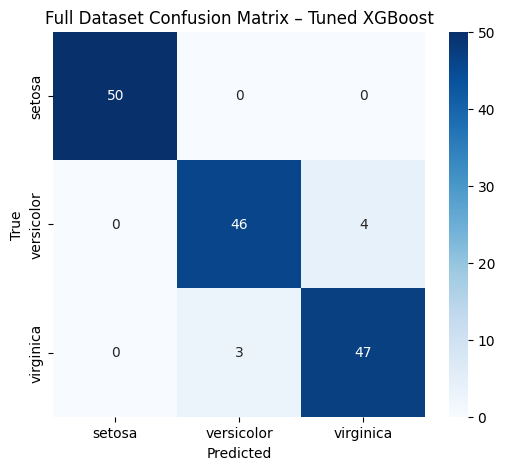

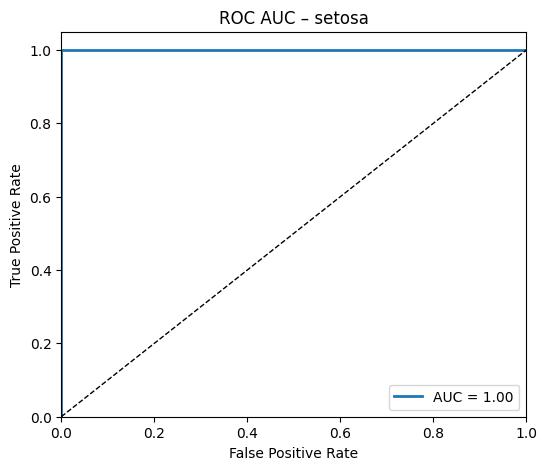

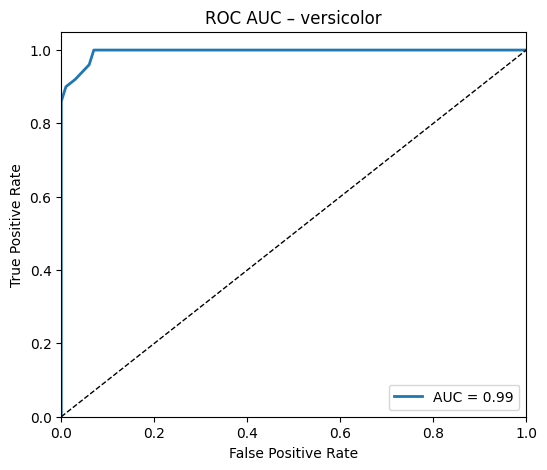

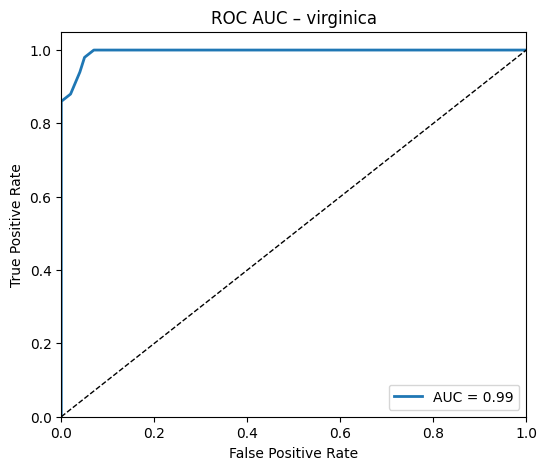


=== Final Test Accuracies ===
KNN (base): 0.8947
SVM (base): 0.9211
Logistic Regression (base): 0.8947
XGBoost (base): 0.9211
XGBoost (tuned): 0.9211


In [15]:
!pip install -q optuna xgboost seaborn scikit-learn matplotlib pandas numpy

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
import logging
logging.getLogger("xgboost").setLevel(logging.CRITICAL)

# 1. LOAD DATA
data = load_iris()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = data.target

print("Dataset shape:", X.shape)
display(X.head())

# 2. FEATURE ENGINEERING
X['sepal_ratio'] = X['sepal length (cm)'] / X['sepal width (cm)']
X['petal_ratio'] = X['petal length (cm)'] / X['petal width (cm)']

# 3. STANDARDIZATION
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. TRAIN-TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.25, random_state=42, stratify=y
)

# 5. BASE MODELS
models = {
    "KNN": KNeighborsClassifier(),
    "SVM": SVC(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=300),
    "XGBoost": XGBClassifier(eval_metric='mlogloss', random_state=42)
}

results = {}
print("\n=== Base Models (Test Accuracy) ===")
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    results[name] = acc
    print(f"{name}: {acc:.4f}")

# 6. OPTUNA HYPERPARAMETER TUNING FOR XGBoost
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 5),
    }
    model = XGBClassifier(**params, eval_metric='mlogloss', random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy').mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=False)

best_params = study.best_params
print("\nBest Parameters:", best_params)
print("Best CV Accuracy:", f"{study.best_value:.4f}")

# 7. TRAIN BEST XGBoost MODEL
best_xgb = XGBClassifier(**best_params, eval_metric='mlogloss', random_state=42)
best_xgb.fit(X_train, y_train)
xgb_preds_test = best_xgb.predict(X_test)
xgb_preds_full = best_xgb.predict(X_scaled)  # полный dataset

print("\n=== Tuned XGBoost (Test Set Performance) ===")
print("Accuracy:", accuracy_score(y_test, xgb_preds_test))
print("F1 Score (weighted):", f1_score(y_test, xgb_preds_test, average='weighted'))

# FULL CONFUSION MATRIX & CLASSIFICATION REPORT
print("\n=== Full Dataset Classification Report ===")
print(classification_report(y, xgb_preds_full, target_names=data.target_names))

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix(y, xgb_preds_full), annot=True, fmt='d', cmap="Blues",
            xticklabels=data.target_names, yticklabels=data.target_names)
plt.title("Full Dataset Confusion Matrix – Tuned XGBoost")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 8. ROC AUC для каждого класса отдельно
y_bin = label_binarize(y, classes=[0,1,2])
pred_proba = best_xgb.predict_proba(X_scaled)

for i, class_name in enumerate(data.target_names):
    fpr, tpr, _ = roc_curve(y_bin[:, i], pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC AUC – {class_name}')
    plt.legend(loc="lower right")
    plt.show()

# 9. FINAL TEST ACCURACIES
print("\n=== Final Test Accuracies ===")
for name, acc in results.items():
    print(f"{name} (base): {acc:.4f}")
print(f"XGBoost (tuned): {accuracy_score(y_test, xgb_preds_test):.4f}")
